# Analysis of Differences Between Members and Casual Riders

In [1]:
import pandas as pd
import os

In [2]:
folder_path = 'sources'
contents = os.listdir(folder_path)
for content in contents:
    print(content)

daily_rent_detail.csv
station_list.csv
usage_frequency.csv
weather.csv


In [3]:
df_rent=pd.read_csv("sources/daily_rent_detail.csv")

C:\Users\KEJIA\AppData\Local\Temp\ipykernel_7100\601710630.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_rent=pd.read_csv("sources/daily_rent_detail.csv")


### Proportion of members and casual riders

In [4]:
df_member_casual = df_rent.groupby(["member_casual"]).size().reset_index(name="count")
df_member_casual

,member_casual,count
0,casual,6293515
1,member,9793157


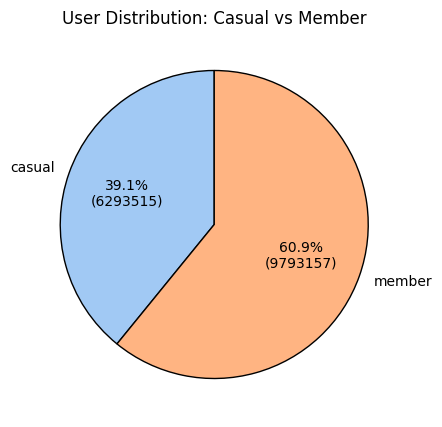

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
labels = df_member_casual['member_casual']
sizes = df_member_casual['count']

pastel_colors = sns.color_palette("pastel", n_colors=len(labels))

# Define a function to display both percentage and count
def func(pct, allvalues):
    absolute = int(pct / 100.*sum(allvalues))  # Calculate absolute value
    return f"{pct:.1f}%\n({absolute})"  # Format the label as percentage and count

# Plotting the pie chart
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct=lambda pct: func(pct, sizes), colors=pastel_colors, startangle=90, wedgeprops={'edgecolor': 'black'})

# Title
plt.title('User Distribution: Casual vs Member')

plt.savefig('member_barchart.png', dpi=300, bbox_inches='tight') 
# Show the plot
plt.show()

### Preferred stations

In [7]:
df_member_start = df_rent.groupby(['start_station_name', 'member_casual']).size().reset_index(name='count')
df_member_start = df_member_start.pivot_table(index='start_station_name', columns='member_casual', values='count', aggfunc='sum', fill_value=0)

df_member_start.columns = ['casual_count', 'member_count']
df_member_start = df_member_start.reset_index()
df_member_start = df_member_start.sort_values(by='member_count', ascending=False)
df_member_start

,start_station_name,casual_count,member_count
639,New Hampshire Ave & T St NW,41184,112474
76,15th & P St NW,37239,103594
343,Columbus Circle / Union Station,47917,99455
130,1st & M St NE,45485,84976
219,5th & K St NW,32081,82243
...,...,...,...
364,Crabbs Branch Way & Calhoun Pl,23,1
735,Roland Clarke Pl & Sunrise Valley Dr,1,0
589,Minnesota Ave & D St SE,1,0
612,N Moore St & Rosslyn Metro,1,0


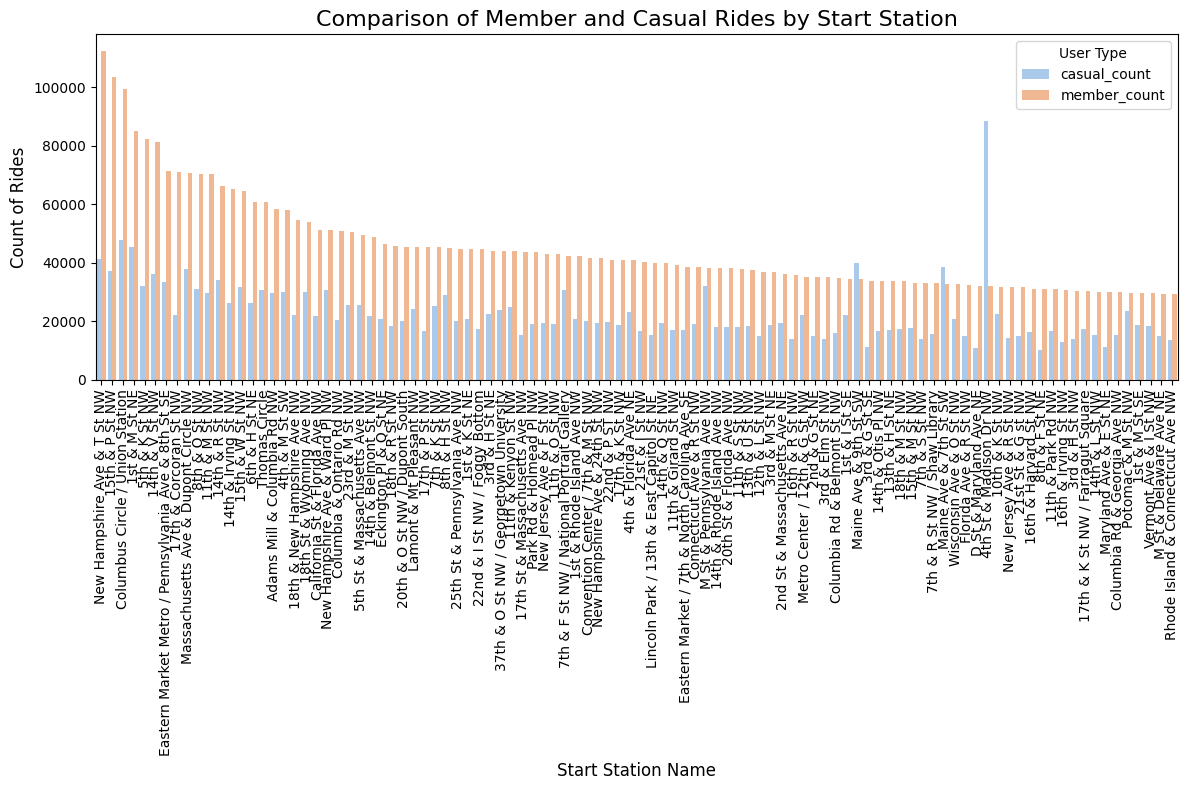

In [11]:
df_member_start_melted = df_member_start.head(100).melt(id_vars='start_station_name', 
                                                       value_vars=['casual_count', 'member_count'], 
                                                       var_name='member_casual', 
                                                       value_name='count')
plt.figure(figsize=(12, 8))
sns.barplot(data=df_member_start_melted, 
            x='start_station_name', 
            y='count', 
            hue='member_casual', 
            palette='pastel', 
            dodge=True)
plt.title('Comparison of Member and Casual Rides by Start Station', fontsize=16)
plt.xlabel('Start Station Name', fontsize=12)
plt.ylabel('Count of Rides', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.legend(title='User Type', fontsize=10)
plt.tight_layout()
plt.savefig('member_station.png', dpi=300, bbox_inches='tight') 
plt.show()

This chart shows the number of member and casual riders by start station (sorted by member count in descending order, taking the top 100). From the chart, it is evident that most stations have more member riders than casual riders. However, there are also stations where casual riders outnumber members, so I further extracted the stations with more casual riders. --Kejia Ruan

In [12]:
df_member_start['casual_ratio'] = df_member_start['casual_count'] / (df_member_start['casual_count'] + df_member_start['member_count'])
df_casual_more_than_member = df_member_start[df_member_start['casual_count'] > df_member_start['member_count']]
df_casual_more_than_member = df_casual_more_than_member.sort_values(by='casual_count', ascending=False)
casual_more_ratio = len(df_casual_more_than_member) / len(df_member_start)

print("Stations where casual riders outnumber members, sorted by casual rider count:")
# print(df_casual_more_than_member[['start_station_name', 'casual_count', 'member_count', 'casual_ratio']])
df_casual_more_than_member

Stations where casual riders outnumber members, sorted by casual rider count:


,start_station_name,casual_count,member_count,casual_ratio
544,Lincoln Memorial,112739,26005,0.812568
486,Jefferson Dr & 14th St SW,100386,25427,0.797898
214,4th St & Madison Dr NW,88593,32019,0.734529
478,Henry Bacon Dr & Lincoln Memorial Circle NW,88049,19976,0.815080
775,Smithsonian-National Mall / Jefferson Dr & 12t...,82579,24061,0.774372
...,...,...,...,...
305,Broschart & Blackwell Rd,7,1,0.875000
735,Roland Clarke Pl & Sunrise Valley Dr,1,0,1.000000
589,Minnesota Ave & D St SE,1,0,1.000000
612,N Moore St & Rosslyn Metro,1,0,1.000000


In [13]:
print(f"Percentage of such stations among all stations: {casual_more_ratio:.2%}")

Percentage of such stations among all stations: 37.03%


In [25]:
stats_with_type = pd.read_csv('stats_with_type.csv').dropna(subset=['avg_lat', 'avg_lng'])

In [26]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex, LinearSegmentedColormap
import seaborn as sns

import folium
from folium import plugins

map_center = [38.9078, -77.0369]

# Find the maximum and minimum values of start_count
max_count = stats_with_type['start_count'].max()
min_count = stats_with_type['start_count'].min()

# Normalization function to map start_count to a suitable range for display
def normalize_radius(count, min_count, max_count, min_radius=5, max_radius=200):
     # Normalize start_count to the range [min_radius, max_radius]
    return min_radius + (count - min_count) * (max_radius - min_radius) / (max_count - min_count)

palette = sns.color_palette("muted", n_colors=2)
member_color = palette[1]
casual_color = palette[0]

def get_color(member_count, casual_count):
    if member_count > casual_count:
        return to_hex(member_color)
    else:
        return to_hex(casual_color)

washington_map_member = folium.Map(location=map_center, zoom_start=13)

for _, row in stats_with_type.iterrows():
    station_name = row['station_name']
    lat = row['avg_lat']
    lng = row['avg_lng']
    start_count = row['start_count']
    member_count = row['start_member_count']
    casual_count = row['start_casual_count']

    radius = normalize_radius(start_count, min_count, max_count)

    fill_color = get_color(member_count, casual_count)

    circle_marker = folium.Circle(
        location=[lat, lng],
        radius=radius,
        color='transparent',
        fill=True,
        fill_color=fill_color,
        fill_opacity=0.8,
    ).add_to(washington_map_member)

    folium.Tooltip(
        f"{station_name}<br>Rides: {start_count}<br>Members: {member_count}<br>Casual: {casual_count}",
        sticky=True,
    ).add_to(circle_marker)

legend_html = """
<div style="position: fixed; 
            top: 10px; right: 10px; width: auto; height: auto; 
            background-color: rgba(255, 255, 255, 0.8); z-index:9999; font-size:14px;
            border:1px solid #ddd; border-radius: 5px; padding: 10px; box-shadow: 2px 2px 5px rgba(0,0,0,0.3);">
    <div style="margin-bottom: 5px; font-weight: bold;">Legend:</div>
    <i style="background: {member_color}; width: 12px; height: 12px; display: inline-block; margin-right: 5px; border-radius: 50%;"></i> Mostly Members<br>
    <i style="background: {casual_color}; width: 12px; height: 12px; display: inline-block; margin-right: 5px; border-radius: 50%;"></i> Mostly Casual
</div>
""".format(member_color=to_hex(member_color), casual_color=to_hex(casual_color))

washington_map_member.get_root().html.add_child(folium.Element(legend_html))

washington_map_member

### Ride duration

In [15]:
# delete milliseconds to avoid ValueError
df_rent['started_at'] = df_rent['started_at'].str.replace(r'\.\d+', '', regex=True)
df_rent['ended_at'] = df_rent['ended_at'].str.replace(r'\.\d+', '', regex=True)

In [16]:
df_rent_duration = df_rent.copy()
df_rent_duration['started_at'] = pd.to_datetime(df_rent_duration['started_at'])
df_rent_duration['ended_at'] = pd.to_datetime(df_rent_duration['ended_at'])

df_rent_duration['ride_duration'] = (df_rent_duration['ended_at'] - df_rent_duration['started_at']).dt.total_seconds() / 60  # 转换为分钟
df_rent_duration

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration
0,946D42AD89539210,docked_bike,2020-05-30 17:25:29,2020-05-31 18:25:22,Anacostia Library,31804,11th & H St NE,31614.0,38.865784,-76.978400,38.899983,-76.991383,casual,1499.883333
1,CC46FAAB662B8613,docked_bike,2020-05-09 14:42:04,2020-05-09 15:06:33,10th & E St NW,31256,21st St & Constitution Ave NW,31261.0,38.895914,-77.026064,38.892459,-77.046567,member,24.483333
2,72F00B2FB833D6ED,docked_bike,2020-05-24 17:27:19,2020-05-24 17:43:51,Connecticut Ave & Newark St NW / Cleveland Park,31305,12th & U St NW,31268.0,38.934267,-77.057979,38.916787,-77.028139,member,16.533333
3,4DFBE6AED989DF35,docked_bike,2020-05-27 15:29:52,2020-05-27 15:47:13,Connecticut Ave & Newark St NW / Cleveland Park,31305,14th & Belmont St NW,31119.0,38.934267,-77.057979,38.921074,-77.031887,casual,17.350000
4,1AAFE6B4331AB9DF,docked_bike,2020-05-31 14:06:03,2020-05-31 14:30:30,Georgia Ave & Morton St NW,31419,17th & K St NW,31213.0,38.932128,-77.023500,38.902760,-77.038630,casual,24.450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16086667,117C27DBDD138B72,electric_bike,2024-08-01 08:10:22,2024-08-01 08:10:37,NaN,NaN,NaN,NaN,38.890000,-77.000000,38.890000,-77.000000,member,0.250000
16086668,4774F4D630258482,electric_bike,2024-08-08 10:05:21,2024-08-08 10:21:46,NaN,NaN,NaN,NaN,38.900000,-77.000000,38.870000,-76.950000,member,16.416667
16086669,D75836E25E77B5EC,electric_bike,2024-08-03 16:29:32,2024-08-03 16:35:43,NaN,NaN,NaN,NaN,38.920000,-76.990000,38.920000,-77.000000,member,6.183333
16086670,3B888603D18116DC,electric_bike,2024-08-03 02:49:45,2024-08-03 02:59:56,NaN,NaN,NaN,NaN,38.920000,-77.020000,38.920000,-77.030000,member,10.183333


In [17]:
df_rent_duration = df_rent_duration[df_rent_duration['ride_duration'] >= 0]
df_rent_duration = df_rent_duration[df_rent_duration['ride_duration'] <= 120]
df_rent_duration['ride_duration'].describe()

count    1.587129e+07
mean     1.618118e+01
std      1.632727e+01
min      0.000000e+00
25%      6.416667e+00
50%      1.120000e+01
75%      1.956667e+01
max      1.200000e+02
Name: ride_duration, dtype: float64

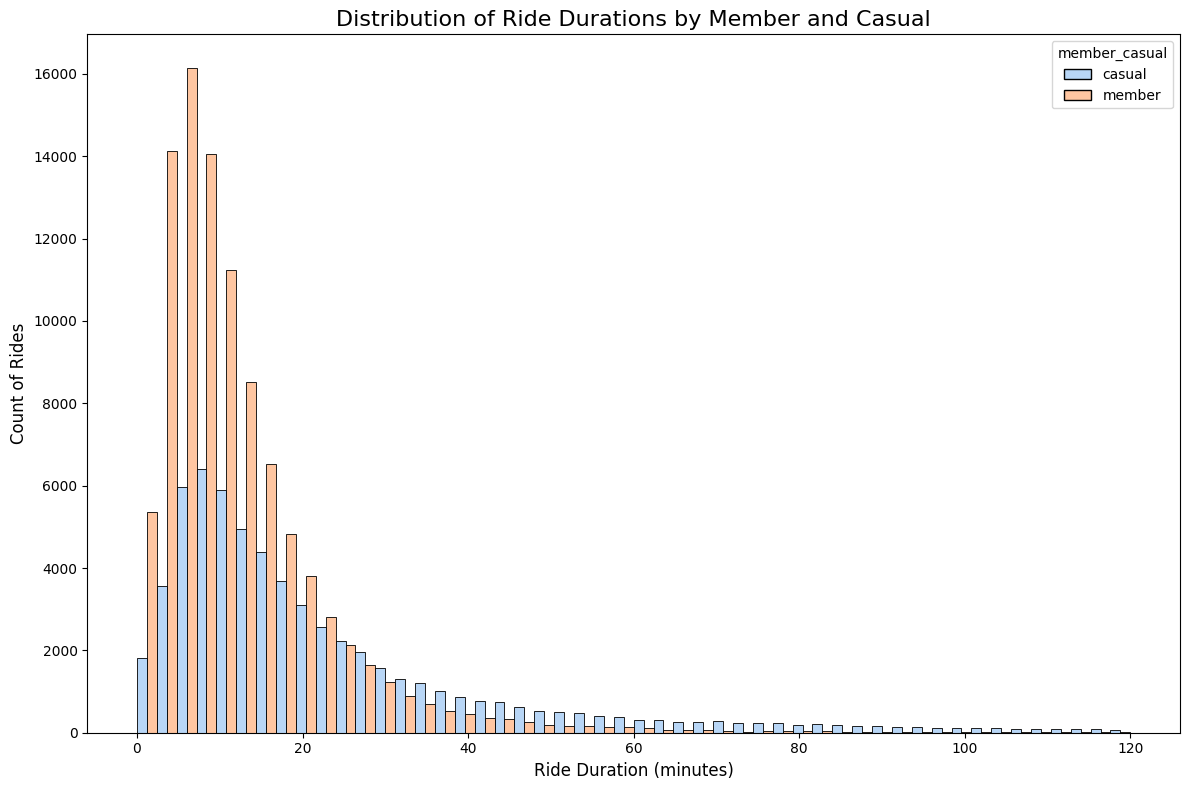

In [19]:
df_sample = df_rent_duration.sample(frac=0.01, random_state=42)

plt.figure(figsize=(12, 8))
sns.histplot(data=df_sample, x='ride_duration', hue='member_casual', multiple='dodge', bins=50, palette='pastel', hue_order=['casual', 'member']) 

plt.title('Distribution of Ride Durations by Member and Casual', fontsize=16)
plt.xlabel('Ride Duration (minutes)', fontsize=12)
plt.ylabel('Count of Rides', fontsize=12)

plt.tight_layout()
plt.savefig('member_ride_duration.png', dpi=300, bbox_inches='tight') 
plt.show()

From the histogram above, it can be seen that for rides under 30 minutes, members are significantly more numerous than casual riders. However, for longer rides, casual riders are more frequent.

It can be inferred that individuals who engage in long rides are less likely to become members, while those who take frequent short rides are more inclined to join as members.